In [25]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets

# It is a representation of a Gaussian mixture model probability distribution.
# This class allows to estimate the parameters of a Gaussian mixture idstribution
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
from sklearn.mixture import GaussianMixture

# sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
# stratified K-Folds cross-validator. The folds are made by preserving the percentage of samples for each class
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
from sklearn.model_selection import StratifiedKFold

colors = ['navy', 'turquoise', 'darkorange']

In [26]:
def make_ellipses(gmm, ax):
    # covariances_: array-like -> the covariance of each mixture component. The shape depends on covariance_type
    # (n_components,)                        if 'spherical',
    # (n_features, n_features)               if 'tied',
    # (n_components, n_features)             if 'diag',
    # (n_components, n_features, n_features) if 'full'
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            # the np.diag(v:array_like, k=0) is used for extract a diagonal or construct a diagonla array
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            # the np.eye() returns a 2d array with ones on the diagonal and zeros elsewhere
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        
        # linalg.eight(a, UPLO='L') return the rigenvalues and eigenvecors of a complex Hemitian or 
        # a real symmetric matrix. 
        # v is a 1d array containing the eigenvalues of a
        # w is a 2d square array or matrix of the corresponding eigenvactors
        v, w = np.linalg.eigh(covariances)
        
        u = w[0]/ np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.* np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

In [27]:
iris = datasets.load_iris()

skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
X_test = iris.data[test_index]
y_train = iris.target[train_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# try GMM using different types of covariances
estimators = {cov_type: GaussianMixture(n_components=n_classes, 
                                        covariance_type=cov_type,
                                        max_iter=20,
                                        random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=.95, hspace=.15, wspace=.05, left=.01, right=.99)

<Figure size 432x432 with 0 Axes>

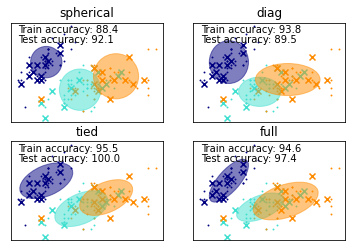

In [28]:
for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
    
    estimator.fit(X_train)
    
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)
    
    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n])
    
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
    
    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(.05, .9, 'Train accuracy: %.1f' % train_accuracy, transform=h.transAxes)
    
    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(.05, .8, 'Test accuracy: %.1f' % test_accuracy, transform=h.transAxes)
    
    plt.xticks(())
    plt.yticks(())
    plt.title(name)

No handles with labels found to put in legend.


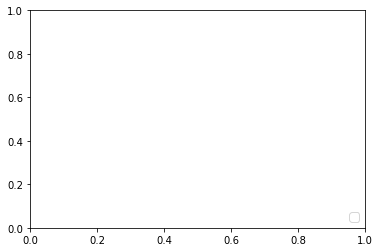

In [29]:
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

plt.show()